In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/code/data/train/subtask_1/en/')
#os.chdir('/content/drive/My Drive/Colab Notebooks/code/data/test/subtask_1/en/')
#os.chdir('/content/drive/My Drive/Colab Notebooks/code/experiments/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%pip install lexicalrichness
%pip install pandas
%pip install numpy
%pip install
%pip install matplotlib
%pip install textacy
%pip install spacy
%pip install nltk
%pip install transformers

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pyparsing/results.py", line 184, in __init__
    self[name] = toklist[0]
TypeError: 'int' object is not subscriptable

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrappe

In [ ]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from lexicalrichness import LexicalRichness
import spacy
import textacy
from textacy.text_stats import readability
from matplotlib.mlab import GaussianKDE
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df1 = pd.read_csv("gpt.csv")
df2 = pd.read_csv("human.csv")
df = pd.concat([df1, df2], ignore_index=True)
df=df.drop(df.columns[0], axis=1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   object
 2   model   2000 non-null   object
 3   domain  2000 non-null   object
 4   id      2000 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 78.2+ KB


In [ ]:
df.head()

,text,label,model,domain,id
0,"this tweet is for josie! Hey Josie, just wante...",generated,gpt-3.5-turbo,tweets,40000
1,@claudia10 yea i read your @claudia10 yea I re...,generated,gpt-3.5-turbo,tweets,40001
2,Proud of myself and saved That's great to hear...,generated,gpt-3.5-turbo,tweets,40002
3,@DamiRadke nice! i wanna get Great to hear tha...,generated,gpt-3.5-turbo,tweets,40003
4,Has some one built a Has someone built a bette...,generated,gpt-3.5-turbo,tweets,40004


In [ ]:
df['domain'].value_counts()

domain
tweets    684
legal     660
wiki      656
Name: count, dtype: int64

In [ ]:
df['model'].value_counts()

model
gpt-3.5-turbo    1000
NO-MODEL         1000
Name: count, dtype: int64

## LexicalRichness metrics


In [ ]:
# Function to calculate lexical richness metrics for each text
def calculate_lexical_metrics(text):
    lex = LexicalRichness(text)
    if lex.words != lex.terms:  # Check if words are not all unique
        window = min(25, lex.words - 1) if lex.words > 1 else 1
        draw = min(lex.words, 42)
        return {
            'Word count': lex.words,
            '(Unique) Word count': lex.terms,
            'Type-token ratio (TTR)': lex.ttr,
            'Root type-token ratio (RTTR)': lex.rttr,
            'Corrected type-token ratio (CTTR)': lex.cttr,
            'Mean segmental type-token ratio (MSTTR)': lex.msttr(segment_window=window),
            'Measure of Textual Lexical Diversity (MTLD)': lex.mtld(threshold=0.72),
            'Hypergeometric distribution diversity (HD-D)': lex.hdd(draws=draw),
            "Herdan's lexical diversity measure": lex.Herdan,
            "Summer's lexical diversity measure": lex.Summer,
            "Dugast's lexical diversity measure": lex.Dugast,
            "Maas's lexical diversity measure": lex.Maas,
            "Yule's K": lex.yulek,
            "Yule's I": lex.yulei,
            "Herdan's Vm": lex.herdanvm,
            "Simpson's D": lex.simpsond
        }
    else:
        # If all words are unique, return None
        return None

lex_metrics_df = df['text'].apply(lambda text: pd.Series(calculate_lexical_metrics(text)))

# Concatenate the original DataFrame with the DataFrame containing lexical richness metrics
df_with_lex_metrics = pd.concat([df, lex_metrics_df], axis=1)


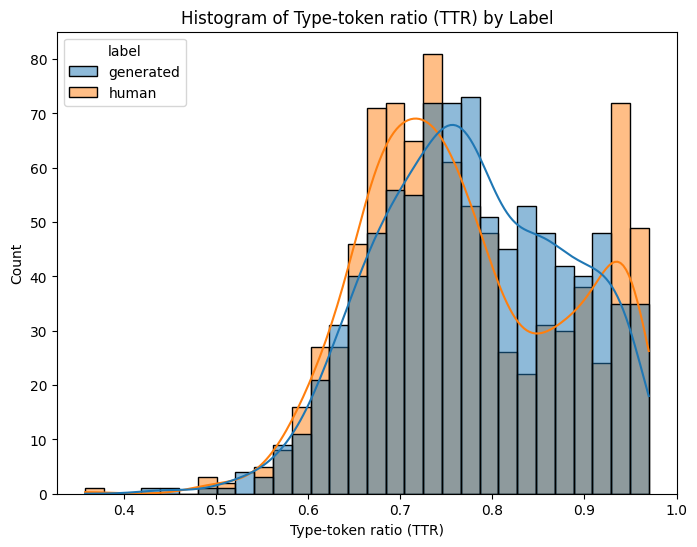

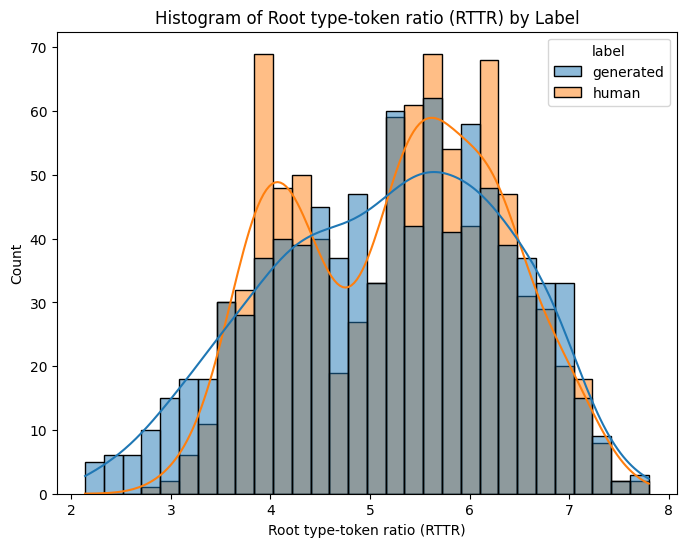

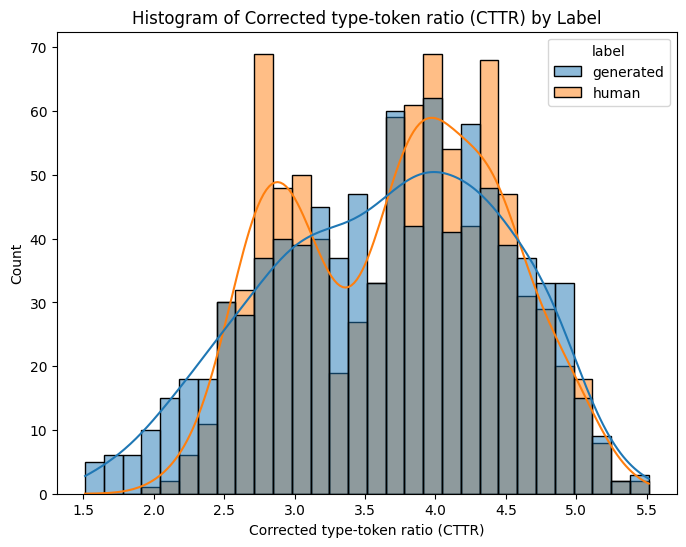

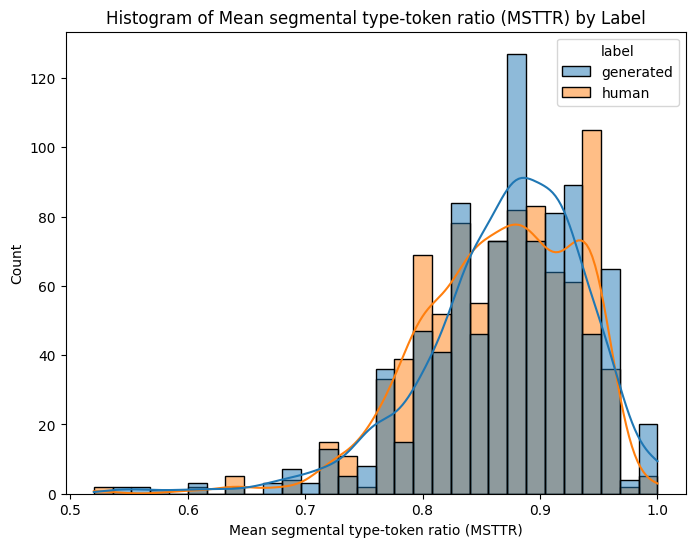

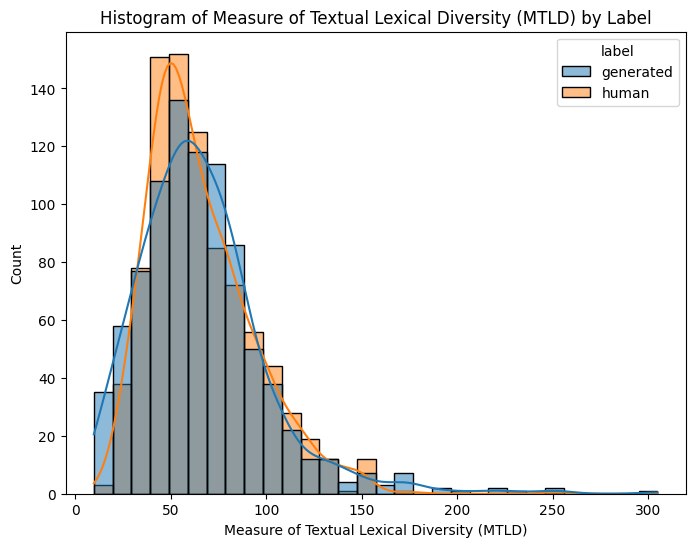

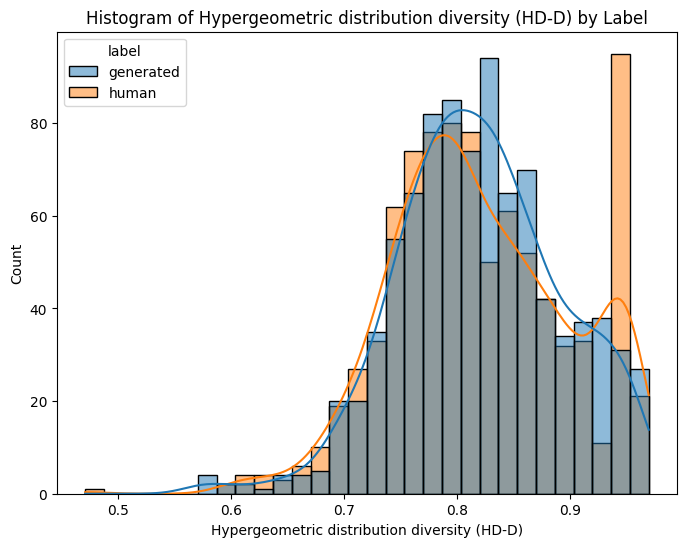

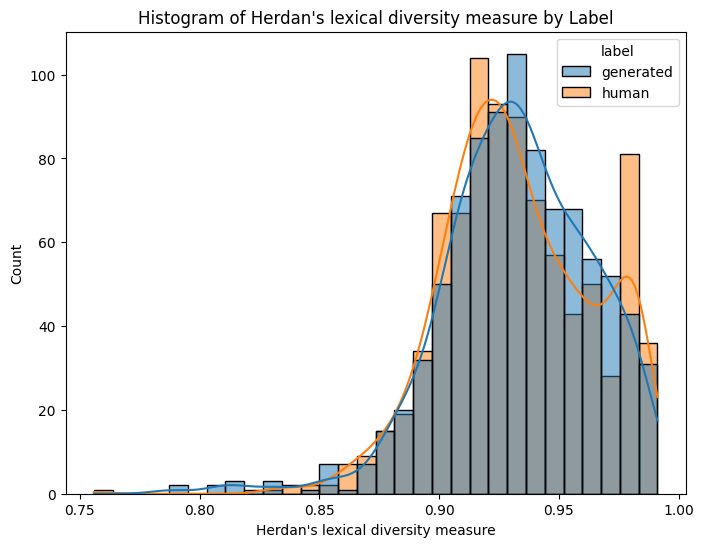

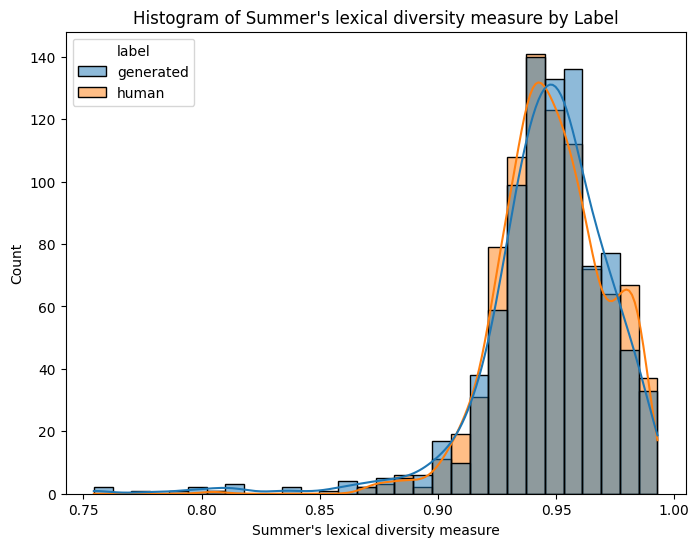

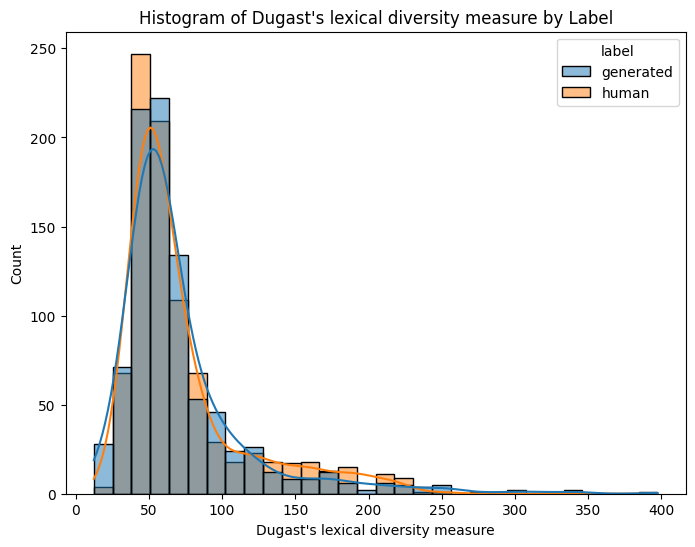

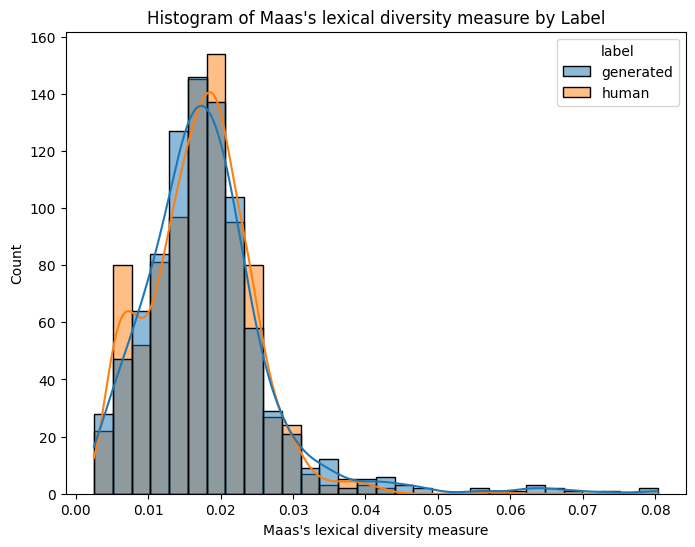

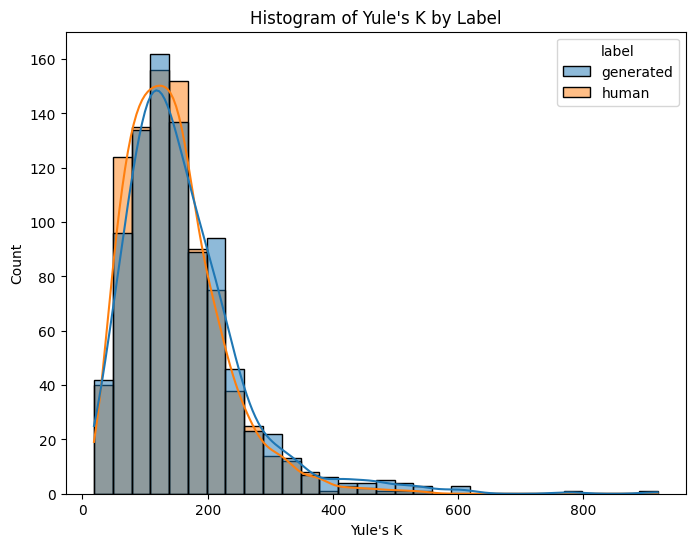

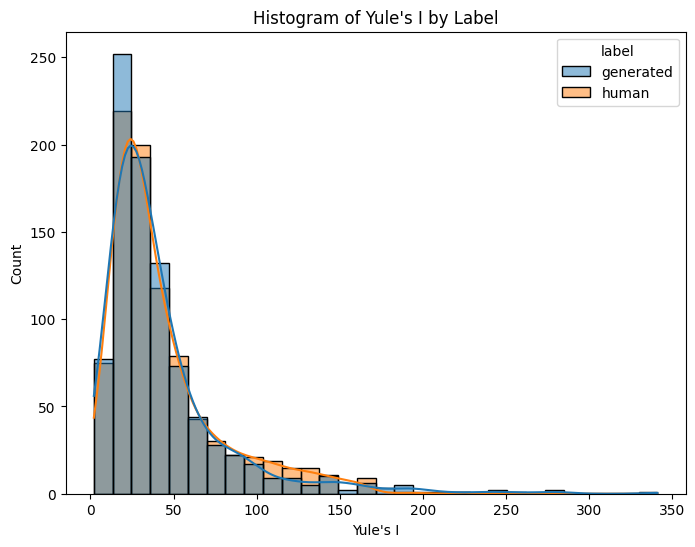

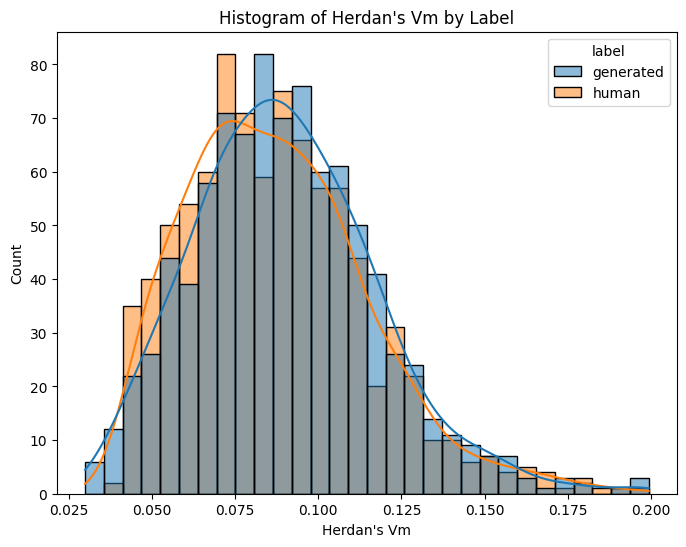

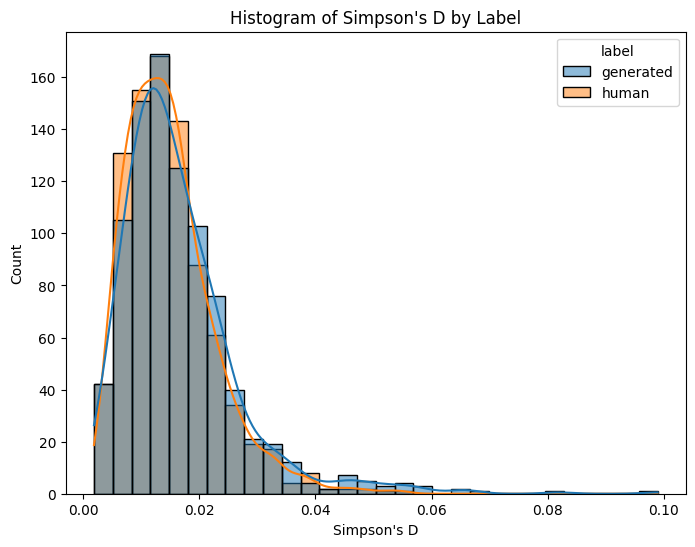

In [ ]:
lexical_richness_metrics = ['Type-token ratio (TTR)' , 'Root type-token ratio (RTTR)', 'Corrected type-token ratio (CTTR)','Mean segmental type-token ratio (MSTTR)',  'Measure of Textual Lexical Diversity (MTLD)','Hypergeometric distribution diversity (HD-D)', "Herdan's lexical diversity measure", "Summer's lexical diversity measure","Dugast's lexical diversity measure", "Maas's lexical diversity measure",  "Yule's K", "Yule's I","Herdan's Vm",  "Simpson's D" ]

for metric in lexical_richness_metrics:
    plt.figure(figsize=(8,6))
    sns.histplot(data=df_with_lex_metrics, x=metric, hue='label', bins=30, kde=True, multiple='layer', stat='count')
    plt.title(f'Histogram of {metric} by Label')
    plt.show()

## Readability metrics

In [ ]:
model_path = "en_core_web_sm"
nlp = spacy.load(model_path)

def get_readability_stats(texts):
    stats_list = []
    for ix, article in enumerate(texts):
        doc = nlp(article)
        stats = {
            'Automated Readability Index': readability.automated_readability_index(doc),
            'Coleman-Liau Index': readability.coleman_liau_index(doc),
            'Flesch-Kincaid Grade Level': readability.flesch_kincaid_grade_level(doc),
            'Flesch Readability Ease': readability.flesch_reading_ease(doc),
            'Gunning Fog Index': readability.gunning_fog_index(doc),
            'N Characters': len(doc.text),
            'N Unique Words': len(set(token.text.lower() for token in doc if token.is_alpha)),
            'N Words': len(doc),
            'SMOG Index': readability.smog_index(doc)
        }
        stats_list.append(stats)
    return pd.DataFrame(stats_list)

readability_stats = get_readability_stats(df['text'])
df = pd.concat([df.reset_index(drop=True), readability_stats.reset_index(drop=True)], axis=1)


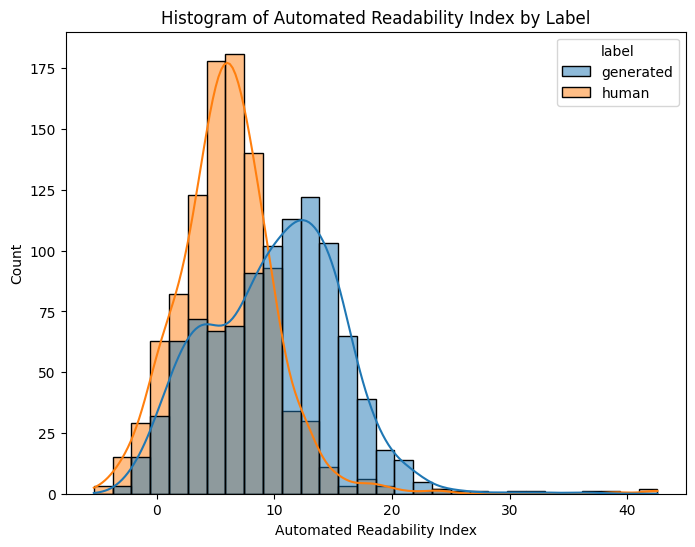

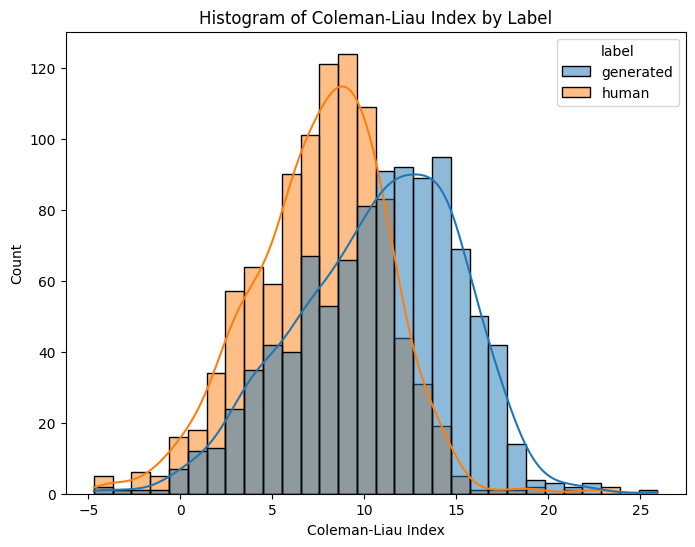

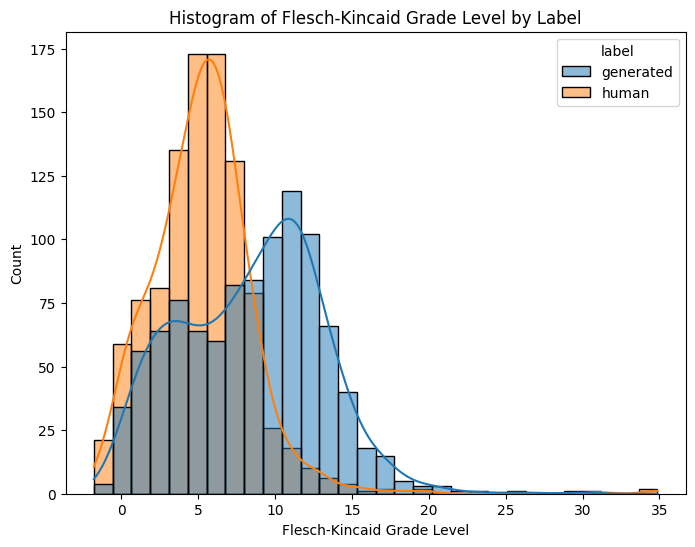

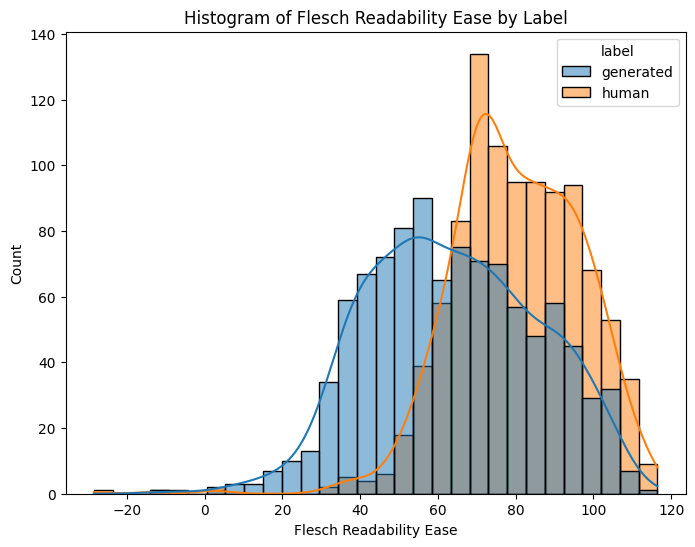

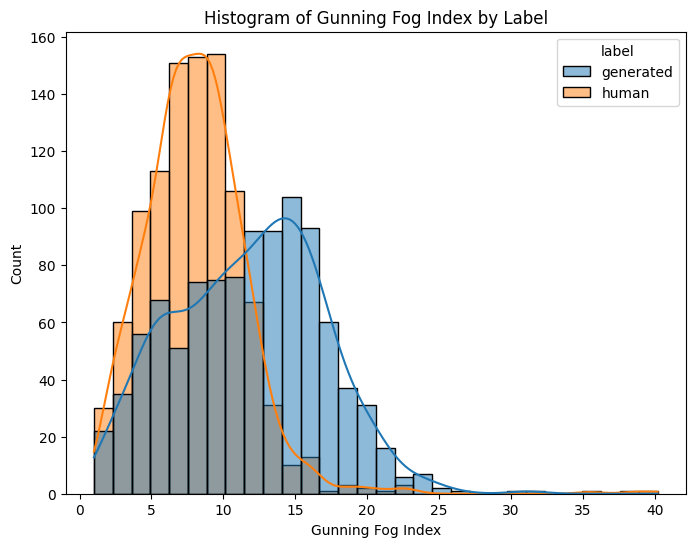

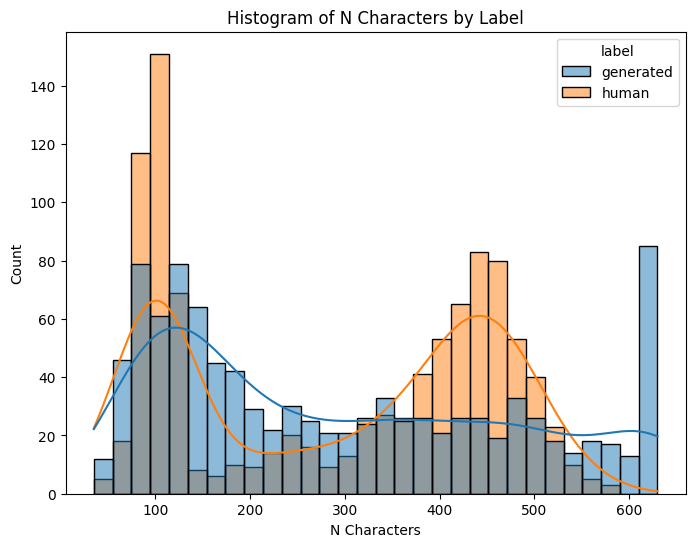

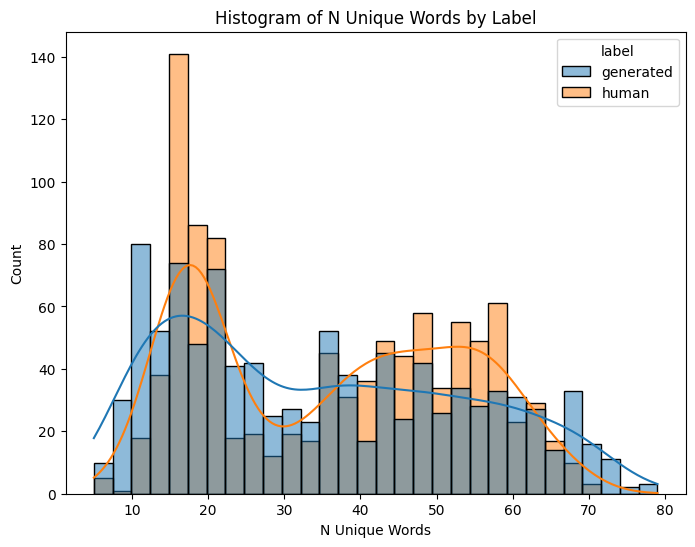

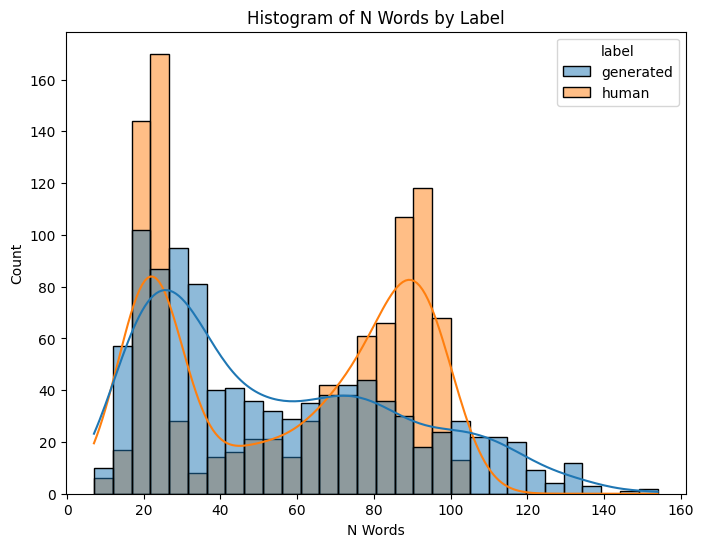

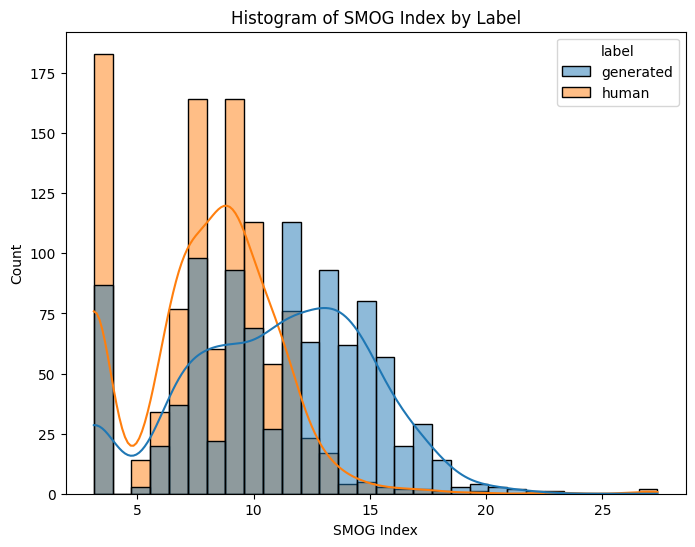

In [ ]:
readability_metrics = ['Automated Readability Index', 'Coleman-Liau Index', 'Flesch-Kincaid Grade Level',
                       'Flesch Readability Ease', 'Gunning Fog Index', 'N Characters',
                       'N Unique Words', 'N Words', 'SMOG Index']

for metric in readability_metrics:
    plt.figure(figsize=(8,6))
    sns.histplot(data=df, x=metric, hue='label', bins=30, kde=True, multiple='layer')
    plt.title(f'Histogram of {metric} by Label')
    plt.show()

In [ ]:
nlp = spacy.load("en_core_web_sm")

def count_clauses(text):
    doc = nlp(text)
    return sum(1 for token in doc if token.dep_ == 'ROOT')

# Apply spaCy to the entire df
docs = list(nlp.pipe(df['text']))

# Initialize lists to store calculated values
n_tokens_list = []
n_sentences_list = []
n_clauses_list = []
avg_sentence_length_list = []

# Iterate over each document to calculate metrics
for doc in docs:
    n_tokens = len(doc)
    n_sentences = len(list(doc.sents))
    n_clauses = count_clauses(doc.text)
    avg_sentence_length = n_tokens / n_sentences

    # Append calculated values to respective lists
    n_tokens_list.append(n_tokens)
    n_sentences_list.append(n_sentences)
    n_clauses_list.append(n_clauses)
    avg_sentence_length_list.append(avg_sentence_length)

# Add calculated metrics to the dataframe
df['N Tokens'] = n_tokens_list
df['N Sentences'] = n_sentences_list
df['N Clauses'] = n_clauses_list
df['Avg Sentence Length'] = avg_sentence_length_list


/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


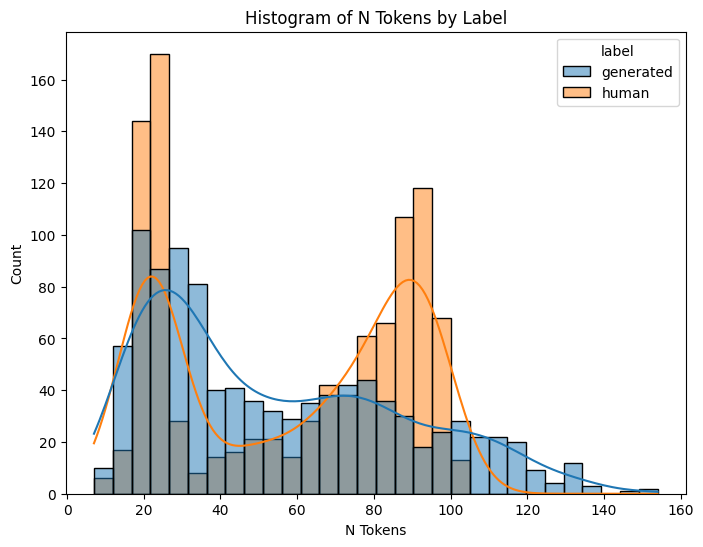

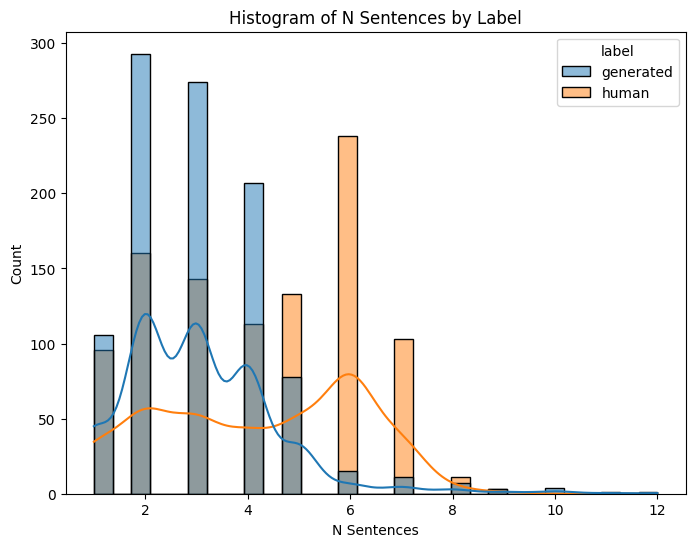

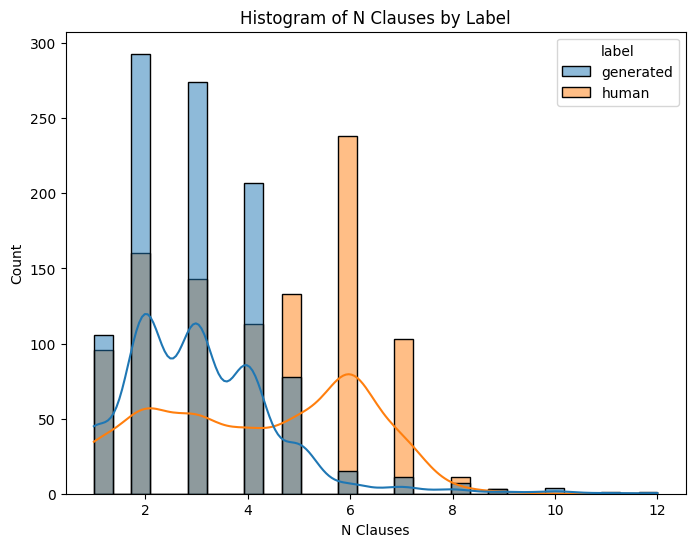

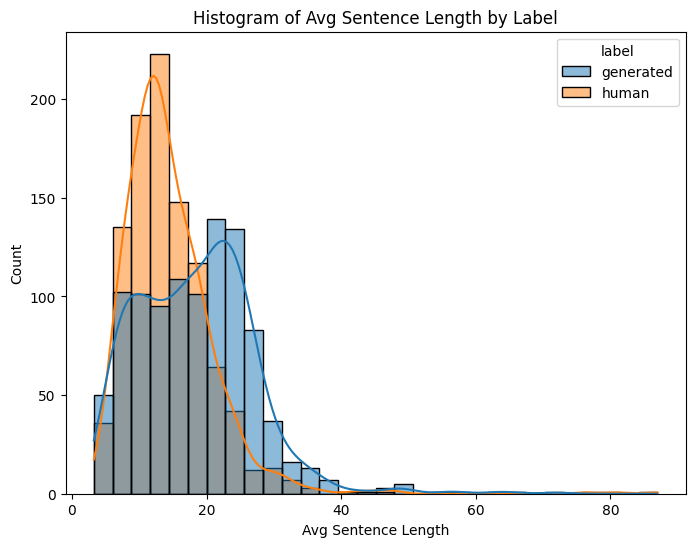

In [ ]:
metrics = ['N Tokens', 'N Sentences', 'N Clauses', 'Avg Sentence Length']

for metric in metrics:
    plt.figure(figsize=(8,6))
    # x='value', hue='category'
    sns.histplot(data=df, x=metric, hue='label', bins=30, kde=True, multiple='layer')
    plt.title(f'Histogram of {metric} by Label')
    plt.show()